# Transfer Learning

In [3]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array


## Getting and checking the data

In [5]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

# Extract files to their respective directories
train_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall('/tmp/train')

val_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_zip, 'r')
zip_ref.extractall('/tmp/val')



In [6]:
# Check the directory structure
for root, dirs, files in os.walk('/tmp'):
  for dir in dirs:
    print(os.path.join(root, dir))

/tmp/initgoogle_syslog_dir.0
/tmp/train
/tmp/pyright-264-1qUc1UftGAZ4
/tmp/val
/tmp/python-languageserver-cancellation
/tmp/pyright-264-9L3x8tA2iHkZ
/tmp/train/humans
/tmp/train/horses
/tmp/val/humans
/tmp/val/horses
/tmp/python-languageserver-cancellation/85236e8f7eede1db48751279bdead9fba942b17211


In [7]:
# Define the directories
train_dir = '/tmp/train'
val_dir = '/tmp/val'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
val_horses_dir = os.path.join(val_dir, 'horses')
val_humans_dir = os.path.join(val_dir, 'humans')

# Check the number of images in the directories
print(f'There are {len(os.listdir(train_horses_dir))} images of horses for training.')
print(f'There are {len(os.listdir(train_humans_dir))} images of humans for training.')
print(f'There are {len(os.listdir(val_horses_dir))} images of horses for validation.')
print(f'There are {len(os.listdir(val_humans_dir))} images of humans for validation.')

There are 500 images of horses for training.
There are 527 images of humans for training.
There are 128 images of horses for validation.
There are 128 images of humans for validation.


In [8]:
# Prepare images for plotting
ind = 0
horses_imgs = [os.path.join(train_horses_dir, f) for f in os.listdir(train_horses_dir)]
humans_imgs = [os.path.join(train_humans_dir, f) for f in os.listdir(train_humans_dir)]

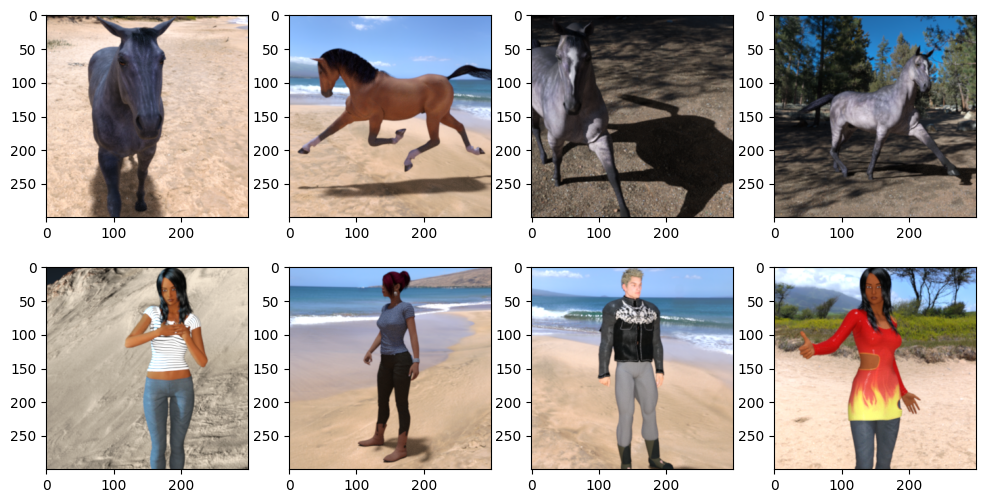

In [13]:
# Plot images of horses and humans
plt.figure(figsize=(12, 6))
for i, img in enumerate(
    (horses_imgs[ind:ind+4]+humans_imgs[ind:ind+4]),
    start=1
    ):
  s = plt.subplot(2, 4, i)
  s.imshow(load_img(img))
ind += 4


In [14]:
# Check image shape
sample_img = load_img(horses_imgs[0])
sample_arr = img_to_array(sample_img)
print(f'Each image has {sample_arr.shape} shape.')

Each image has (300, 300, 3) shape.


## Creating training and validation image data generators

In [15]:
# Get training and validation image data generators
def get_generator(dir, train=True):
  if train:
    datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
  else:
    datagen = ImageDataGenerator(rescale=1/255)

  generator = datagen.flow_from_directory(
      directory=dir,
      target_size=(150, 150),
      batch_size=32,
      class_mode='binary'
  )
  return generator

train_gen = get_generator(train_dir)
val_gen = get_generator(val_dir, train=False)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Transfer Learning

In [16]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-10-25 15:01:44--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.207, 142.250.125.207, 142.250.136.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  29.9MB/s    in 2.8s    

2023-10-25 15:01:47 (29.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [17]:
# Import the Inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [19]:
# Define a pretrained model
pretrained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

# Load weights to the pretrained model
pretrained_model.load_weights(weights_file)

# Set all pretrained model layers untrainable
for layer in pretrained_model.layers:
  layer.trainable = False

pretrained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

## Creating a callback

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.999:
      print('\nReached 99.9% accuracy, so stop training')
      self.model.stop_training=True


## Building and training a CNN

In [23]:
# Get output of the desired last layer in the pretrained model
def get_last_layer_output(pretrained_model):
  # Define the last desired layer of the base (pretrained) model
  last_layer = pretrained_model.get_layer('mixed7')
  print('Last layer output shape: ', last_layer.output_shape)

  # Get the last layer output
  output = last_layer.output
  print('Last layer output: ', output)
  return output

In [24]:
# Build a model based on the pretrained model output
def build_model(pretrained_model):
  output = get_last_layer_output(pretrained_model)
  x = Flatten()(output)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(1)(x)
  model = Model(inputs=pretrained_model.input, outputs=x)

  model.compile(
      loss=tf.losses.BinaryCrossentropy(from_logits=True),
      optimizer=tf.optimizers.RMSprop(learning_rate=0.0001),
      metrics=[
          'accuracy',
          tf.metrics.Precision(thresholds=0),
          tf.metrics.Recall(thresholds=0),
      ]
  )
  return model

In [25]:
model = build_model(pretrained_model)
num_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])
print(f'The model has {num_params} parameters, of which {num_trainable_params} are trainable parameters.')

Last layer output shape:  (None, 7, 7, 768)
Last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
The model has 47512481 parameters, of which 38537217 are trainable parameters.


In [27]:
# Train the model
callbacks = myCallback()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
33/33 [==============================] - 28s 409ms/step - loss: 0.1586 - accuracy: 0.9309 - precision: 0.9337 - recall: 0.9355 - val_loss: 0.0083 - val_accuracy: 1.0000 - val_precision: 0.9922 - val_recall: 1.0000
Epoch 2/100
33/33 [==============================] - 13s 393ms/step - loss: 0.0309 - accuracy: 0.9903 - precision: 0.9887 - recall: 0.9962 - val_loss: 0.0977 - val_accuracy: 0.9648 - val_precision: 0.9209 - val_recall: 1.0000
Epoch 3/100
33/33 [==============================] - 12s 369ms/step - loss: 0.0142 - accuracy: 0.9942 - precision: 0.9943 - recall: 0.9981 - val_loss: 0.0127 - val_accuracy: 0.9961 - val_precision: 0.9922 - val_recall: 1.0000
Epoch 4/100
33/33 [==============================] - 12s 368ms/step - loss: 0.0159 - accuracy: 0.9961 - precision: 0.9962 - recall: 0.9981 - val_loss: 0.0016 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/100
33/33 [==============================] - 12s 366ms/step - loss: 0.0192 - accuracy: 0

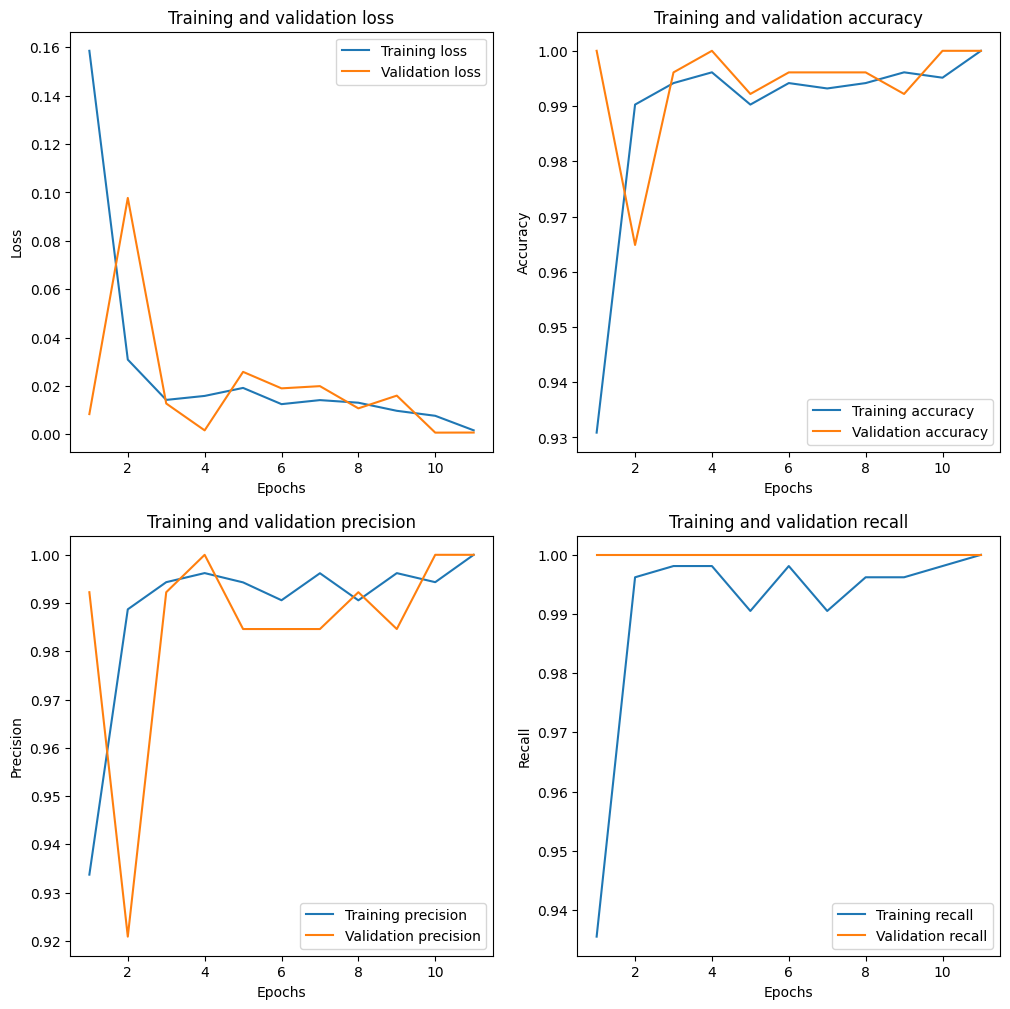

In [28]:
# Plot the model training history
from math import ceil

def plot_history(params: list[str], val=True):
  num_rows = ceil(len(params)/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 6*num_rows))
  for i in range(len(params)):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    s.set_xlabel('Epochs')
    s.set_ylabel(par.capitalize())
    if val:
      s.plot(epochs, history.history[f'val_{par}'], label=f'Validation {par}')
      s.set_title(f'Training and validation {par}')
    else:
      s.set_title(f'Training {par}')
    s.legend()

plot_history(['loss', 'accuracy', 'precision', 'recall'])